# Part I: Simulate view of scene with perspective projection


- Using right-handed coordinates in this example
- E matrix is now E = TR (translation and rotation)

In [ ]:
from google.colab import files
src = list(files.upload().values())[0]
open('helpers.py','wb').write(src)


In [1]:
import helpers
import numpy as np
from helpers import projectPoints, transform_camera
from math import sin, cos, pi

# Define n random points in 1x1x1 cube centred at (0,0,2): 
# n = 20
# np.random.rand(n,3) - 0.5 + np.array([[0,0,2.0]])

p = np.array([[-0.20927748, -0.11965883,  2.48251993],
              [ 0.21500058,  0.46747312,  1.71699167],
              [ 0.13794113,  0.40710104,  2.36350066],
              [-0.1128809 , -0.45828591,  1.68682432],
              [ 0.32599931, -0.23867501,  1.73969982],
              [ 0.00346673, -0.09103035,  1.93506751],
              [ 0.2135272 ,  0.4950768 ,  2.45342722],
              [ 0.27466235, -0.22815187,  2.45607104],
              [-0.47839264,  0.32521683,  2.01613783],
              [-0.31948988,  0.24392884,  1.90082198],
              [-0.02237736, -0.18178899,  2.04393325],
              [-0.06247404,  0.2827452 ,  1.77494647],
              [-0.17425092,  0.20846771,  2.33165073],
              [ 0.16587802, -0.15696543,  2.3328076 ],
              [-0.12601242, -0.47337959,  1.63615567],
              [ 0.10880008, -0.0778482 ,  1.71674749],
              [ 0.41734205,  0.3595651 ,  1.83386047],
              [ 0.19256327,  0.37458334,  2.38535092],
              [-0.30877242, -0.0445262 ,  1.53243441],
              [-0.39356732,  0.03873827,  1.60475767]])

# Define camera parameters

f  = 1          # focal length
bu = bv = 1     # scaling factors
u0 = v0 = 0     # offsets

# Define camera position (0, 0, 0) 
cam_pos = np.array([0.0, 0.0, 0.0])

# Define camera orientation in world coordinates (aligned to world, rows are i, j, k vectors)
cam_or = np.eye(3)

In [2]:
u, v = projectPoints(p, cam_pos, cam_or, f, bu, bv, u0, v0)

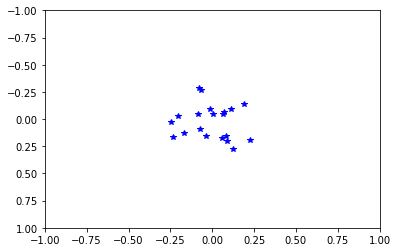

In [3]:
%matplotlib inline 
import matplotlib.pyplot as plt

plt.plot(u, v, 'b*')
plt.axis([-bu, bu, -bv, bv])
plt.gca().invert_yaxis()
plt.show()

## Interactive display of view from different camera positions and orientations 

In [4]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(transform_camera, p=fixed(p),
         x    = (-1.0,+1.0,0.01), y     = (-1.0,+1.0,0.01), z = (0.0,+2.0,0.01),
         roll = (-pi,+pi,0.01),   pitch = (-pi,+pi,0.01),   yaw = (-pi,+pi,0.01),
         f=fixed(1), bu=fixed(1), bv=fixed(1), u0=fixed(0), v0=fixed(0)
        ) 

A Jupyter Widget

<function helpers.transform_camera>

-------------------------
## Part II: Particle Filter with TR as E matrix (assume K = I)

1. Set up two camera positions (translation and rotation)
2. Sample possible translation and rotation in 3 dimensions each, using particle filtering

[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [-0.  0.  1.]]
[0.  0.  1.1]


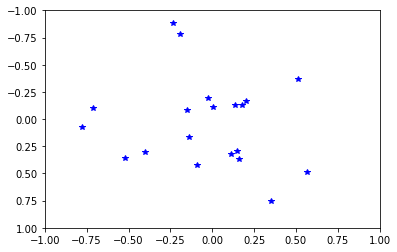

[[ 0.9605305   0.23339191 -0.15135845]
 [-0.19470917  0.95268912  0.23339191]
 [ 0.19866933 -0.19470917  0.9605305 ]]
[-0.2 -0.2  0.9]


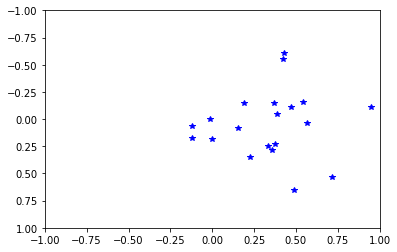

In [5]:
# Set up two camera positions

diff = -0.2
pts1 = transform_camera(p, x=0, y=0, z=1.1, roll=0, pitch=0, yaw=0)
pts2 = transform_camera(p, x=diff, y=diff, z=1.1+diff, roll=diff, pitch=diff, yaw=diff)

#### List pts1 and pts2:

In [6]:
pts1

array([[-0.15137393, -0.08655125],
       [ 0.34846594,  0.7576652 ],
       [ 0.10917377,  0.32220089],
       [-0.19235893, -0.7809593 ],
       [ 0.50961295, -0.3731047 ],
       [ 0.00415144, -0.10900957],
       [ 0.15776777,  0.36579492],
       [ 0.20254274, -0.16824478],
       [-0.52218413,  0.35498679],
       [-0.39895244,  0.30459808],
       [-0.02370651, -0.1925867 ],
       [-0.09256147,  0.418915  ],
       [-0.14147754,  0.16925879],
       [ 0.13455305, -0.12732354],
       [-0.23502954, -0.88291445],
       [ 0.17640944, -0.12622378],
       [ 0.56869401,  0.48996385],
       [ 0.14981377,  0.29142496],
       [-0.71403296, -0.10296637],
       [-0.77971538,  0.07674627]])

In [7]:
pts2

array([[ 1.88184068e-01, -1.51768713e-01],
       [ 4.91012526e-01,  6.53602568e-01],
       [ 3.32255707e-01,  2.48813369e-01],
       [ 4.25456179e-01, -5.55378579e-01],
       [ 9.46616275e-01, -1.08060676e-01],
       [ 3.84137863e-01, -5.08018822e-02],
       [ 3.58402058e-01,  2.86627835e-01],
       [ 5.44083746e-01, -1.54648270e-01],
       [-1.19604185e-01,  1.76318719e-01],
       [-2.19577455e-03,  1.84825641e-01],
       [ 3.66427687e-01, -1.52329528e-01],
       [ 2.27325697e-01,  3.45012567e-01],
       [ 1.56572076e-01,  7.93661781e-02],
       [ 4.71637980e-01, -1.14649397e-01],
       [ 4.28017386e-01, -6.11479055e-01],
       [ 5.67795254e-01,  3.83879015e-02],
       [ 7.16743605e-01,  5.30255301e-01],
       [ 3.73173182e-01,  2.32986922e-01],
       [-1.37924419e-02, -6.19769203e-04],
       [-1.21263908e-01,  5.91154261e-02]])

### Test sampling and scatterplot display functions

In [8]:
from helpers import generate_samples

# Sample m states. Shape of S: (4, n_samples)
m = 100
ranges = np.array([[-0.5, 0.5],
                   [-0.5, 0.5],
                   [-0.5, 0.5],
                   [-pi/4, pi/4],
                   [-pi/4, pi/4],
                   [-pi/4, pi/4], 
                   [1/m, 1/m]])

S = generate_samples(m, ranges)

print("Shape of initial S: " + str(S.shape))

Shape of initial S: (7, 100)


C:\Users\arborea\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:726: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
C:\Users\arborea\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:728: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


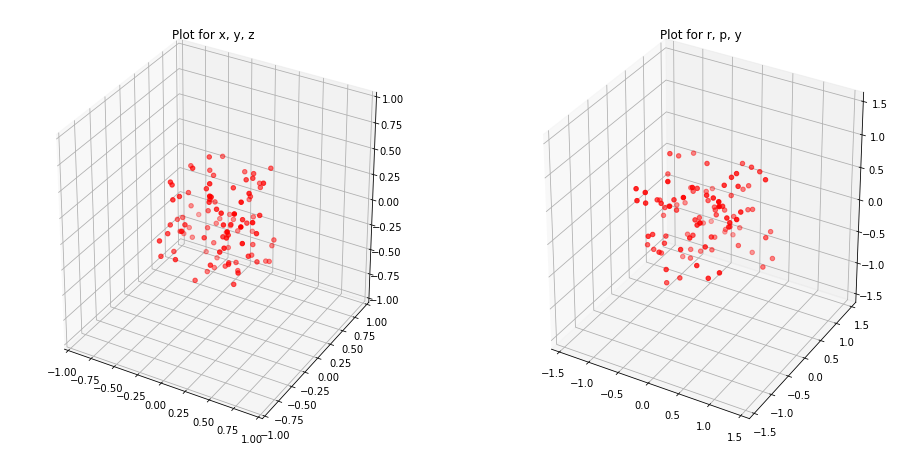

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(*S[:3,:], zdir='z', c= 'red')
ax1.set_xlim3d(-1, 1)
ax1.set_ylim3d(-1, 1)
ax1.set_zlim3d(-1, 1)
ax1.set_title("Plot for x, y, z")

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(*S[3:,:], c= 'red')
ax2.set_xlim3d(-pi/2, pi/2)
ax2.set_ylim3d(-pi/2, pi/2)
ax2.set_zlim3d(-pi/2, pi/2)
ax2.set_title("Plot for r, p, y")
plt.show()

###  Run Particle Filter

In [ ]:
from helpers import ParticleFilter, generate_samples
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

# ---------------------------------------------------------
# Adjustable parameters
# ---------------------------------------------------------

iterations = 50
m = 500
ranges = np.array([[-0.3, -0.1],    # ([[-0.5, 0.5],
                   [-0.3, -0.1],    #   [-0.5, 0.5],
                   [-0.3, -0.1],    #   [-0.5, 0.5],
                   [-0.3, -0.1],    #   [-pi/4, pi/4],
                   [-0.3, -0.1],    #   [-pi/4, pi/4],
                   [-0.3, -0.1],    #   [-pi/4, pi/4], 
                   [1/m, 1/m]])    #   [1/m, 1/m]])
e = 0.0005
sigma =  np.array([0.05] * 6) # np.array([0.1, 0.1, 0.1, 0.3, 0.3, 0.3])

# Multiply sigma by a factor after a number of iterations
sigma_factor   = 0.8
sigma_interval = 3 

# Multiply epsilon by a factor after a number of iterations
e_factor   = 1 # 0.5
e_interval = 10

# ---------------------------------------------------------

S_new = generate_samples(m, ranges)

for i in range(iterations):
    S_new, score_list, nmc, mc = ParticleFilter(S_new, sigma, pts1, pts2, epsilon = e, epipole_t = 0.01, norm_mode = "softmax")
    
    # Print for every 5 iterations, and for the last iteration
    if i%5 == 0 or i+1 == iterations: 
        fig = plt.figure(figsize = (16,8))

        ax1 = fig.add_subplot(121, projection='3d')
        ax1.scatter(*S_new[:3,:], c= 'red')
        ax1.set_xlim3d(-1, 1)
        ax1.set_ylim3d(-1, 1)
        ax1.set_zlim3d(-1, 1)
        ax1.set_title("Plot for x, y, z")

        ax2 = fig.add_subplot(122, projection='3d')
        ax2.scatter(*S_new[3:,:], c= 'red')
        ax2.set_xlim3d(-pi/2, pi/2)
        ax2.set_ylim3d(-pi/2, pi/2)
        ax2.set_zlim3d(-pi/2, pi/2)
        ax2.set_title("Plot for r, p, y")

        plt.show()

        print("First 200 scores: " + str(score_list[:200])) # print first 200 scores only
        print("Non-match ratio: %f (%d/%d)" % (nmc/mc, nmc, mc))
        print("Sigma: " + str(["{0:f}".format(s) for s in sigma]))
        print("Epsilon: %f" % (e))
        print("Iteration: %d" % (i+1))
    
    # Decrease sigma over iterations
    if sigma_factor != 1 and (i+1) % sigma_interval == 0:
        sigma *= sigma_factor
    
    # Decrease epsilon over iterations
    if e_factor != 1 and (i+1) % e_interval == 0:
        e *= e_factor
        
    # Increase sigma and epsilon if all solutions have too few matches (< 30%), usually when epsilon is small 
    # if max(score_list) < pts1.shape[0]*0.3:
    #     sigma_xyz *= 1.3
    #     sigma_rpy *= 1.3
        
    # Stop if more than 3/4 of scores hit maximum
#     if score_list.count(pts1.shape[0]) > (0.75 * m): 
#         break

## Experiment: Start particle filter with ground truth 
- Check that ground truth has perfect score
- Experiment with small m (few samples) and small sigma
- Try increasing sigma and epsilon

C:\Users\arborea\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:726: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
C:\Users\arborea\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:728: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


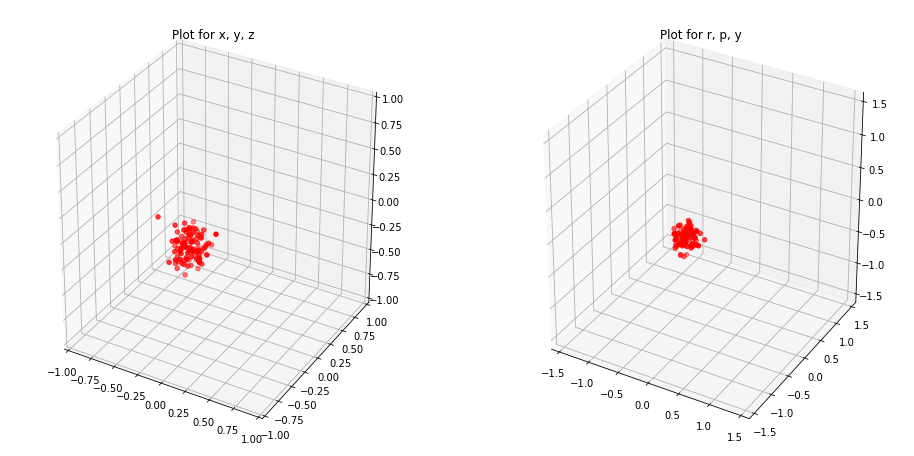

First 200 scores: [1, 1, 1, 2, 0, 2, 1, 3, 0, 0, 3, 0, 0, 1, 0, 0, 1, 1, 2, 0, 1, 0, 3, 0, 3, 2, 2, 2, 2, 2, 3, 6, 0, 2, 0, 1, 1, 3, 1, 0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 1, 3, 1, 2, 2, 0, 2, 1, 1, 0, 1, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 2, 1, 2, 0, 0, 1, 2, 1, 2, 0, 0, 2, 2, 0, 1, 2, 0, 2, 4, 0, 1, 2, 1, 2, 3, 2]
Non-match ratio: 0.852174 (98/115)
Sigma: ['0.100000', '0.100000', '0.100000', '0.100000', '0.100000', '0.100000']
Epsilon: 0.000005
Iteration: 1


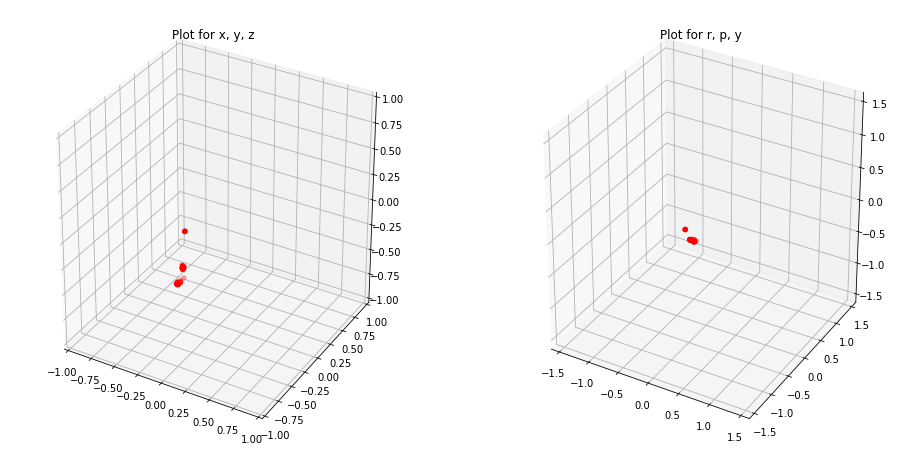

First 200 scores: [1, 4, 5, 3, 6, 2, 1, 1, 4, 3, 3, 5, 4, 5, 3, 4, 4, 2, 2, 3, 7, 5, 1, 4, 3, 6, 3, 4, 4, 4, 2, 0, 3, 7, 3, 5, 2, 3, 3, 3, 4, 5, 5, 5, 3, 4, 2, 7, 4, 7, 2, 2, 3, 2, 5, 3, 5, 4, 5, 5, 5, 4, 3, 5, 4, 4, 2, 4, 5, 2, 4, 4, 2, 4, 5, 4, 5, 5, 5, 5, 4, 2, 2, 2, 3, 5, 5, 5, 6, 4, 4, 5, 2, 4, 6, 3, 3, 4, 6, 2]
Non-match ratio: 0.466844 (176/377)
Sigma: ['0.001024', '0.001024', '0.001024', '0.001024', '0.001024', '0.001024']
Epsilon: 0.000005
Iteration: 6


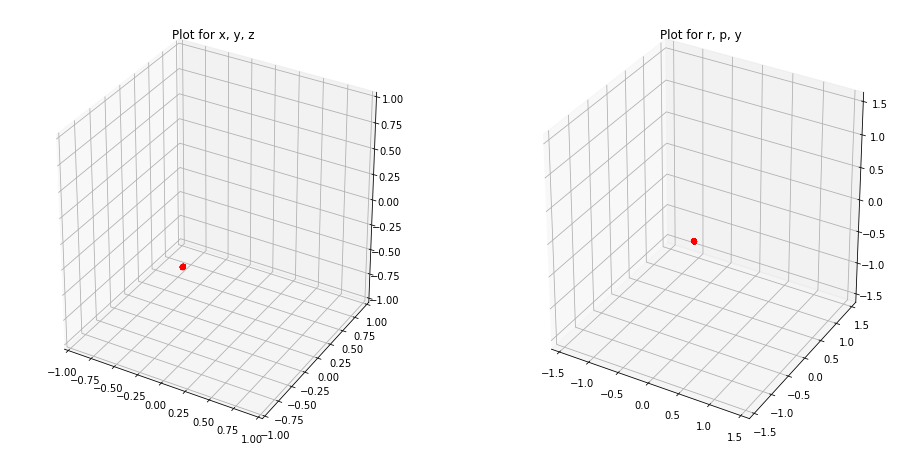

First 200 scores: [8, 8, 8, 8, 8, 7, 9, 8, 9, 8, 7, 7, 9, 8, 9, 9, 9, 8, 9, 6, 8, 8, 9, 8, 8, 9, 8, 9, 8, 8, 8, 8, 8, 8, 8, 8, 9, 8, 9, 9, 8, 9, 8, 8, 8, 8, 9, 7, 8, 9, 8, 8, 9, 8, 8, 8, 8, 9, 8, 8, 9, 9, 7, 8, 9, 8, 8, 9, 7, 8, 8, 8, 9, 8, 7, 7, 9, 9, 8, 8, 9, 8, 9, 8, 6, 9, 8, 8, 8, 8, 9, 8, 8, 8, 8, 9, 9, 8, 7, 8]
Non-match ratio: 0.777506 (636/818)
Sigma: ['0.000010', '0.000010', '0.000010', '0.000010', '0.000010', '0.000010']
Epsilon: 0.000005
Iteration: 11


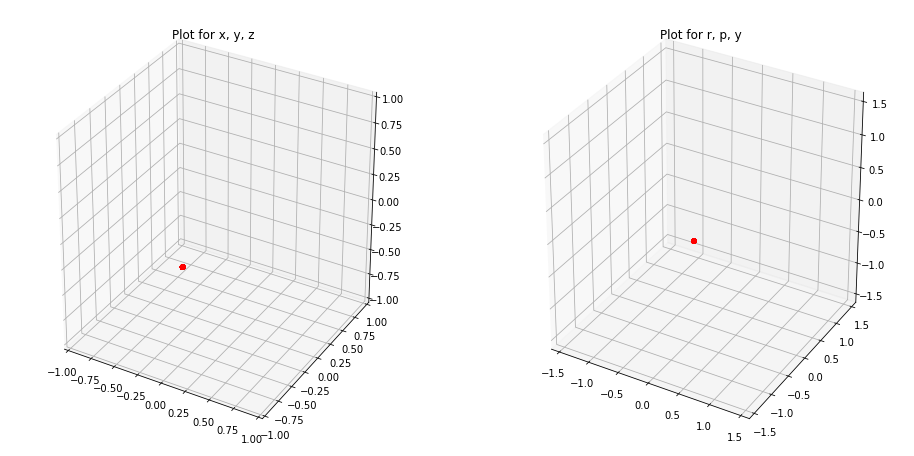

First 200 scores: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
Non-match ratio: 0.777778 (700/900)
Sigma: ['0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000']
Epsilon: 0.000005
Iteration: 16


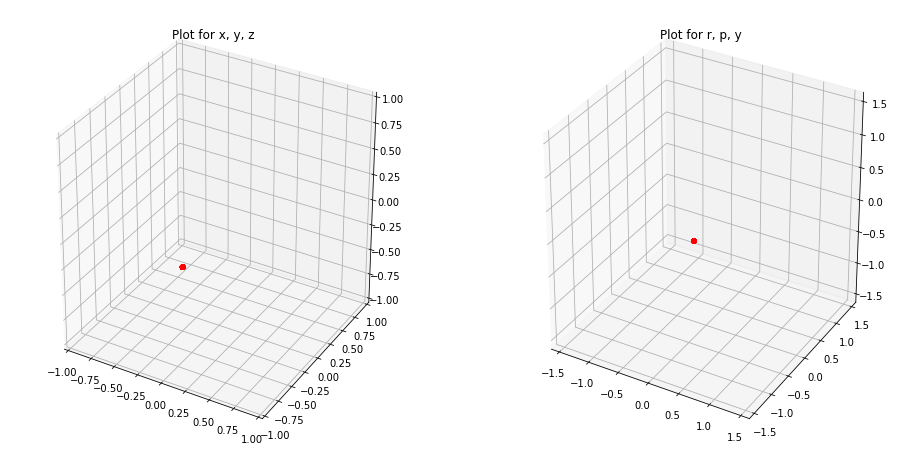

First 200 scores: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
Non-match ratio: 0.777778 (700/900)
Sigma: ['0.000000', '0.000000', '0.000000', '0.000000', '0.000000', '0.000000']
Epsilon: 0.000005
Iteration: 20


In [30]:
from helpers import ParticleFilter, generate_samples
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

# ---------------------------------------------------------
# Adjustable parameters
# ---------------------------------------------------------

iterations = 20
m = 100
ranges = np.array([[-0.2, -0.2],  
                   [-0.2, -0.2],  
                   [-0.2, -0.2],  
                   [-0.2, -0.2],  
                   [-0.2, -0.2],  
                   [-0.2, -0.2],   
                   [1/m, 1/m]])   
e = 0.000005
sigma =  np.array([0.1] * 6) # np.array([0.1, 0.1, 0.1, 0.3, 0.3, 0.3])

# Multiply sigma by a factor after a number of iterations
sigma_factor   = 0.4 #0.8
sigma_interval = 1 

# Multiply epsilon by a factor after a number of iterations
e_factor   = 1 # 0.5
e_interval = 10

# ---------------------------------------------------------

S_new = generate_samples(m, ranges)

for i in range(iterations):
    S_new, score_list, nmc, mc = ParticleFilter(S_new, sigma, pts1, pts2, epsilon = e, epipole_t = 0.1, norm_mode = "softmax")
    
    # Print for every 5 iterations, and for the last iteration
    if i%5 == 0 or i+1 == iterations: 
        fig = plt.figure(figsize = (16,8))

        ax1 = fig.add_subplot(121, projection='3d')
        ax1.scatter(*S_new[:3,:], c= 'red')
        ax1.set_xlim3d(-1, 1)
        ax1.set_ylim3d(-1, 1)
        ax1.set_zlim3d(-1, 1)
        ax1.set_title("Plot for x, y, z")

        ax2 = fig.add_subplot(122, projection='3d')
        ax2.scatter(*S_new[3:,:], c= 'red')
        ax2.set_xlim3d(-pi/2, pi/2)
        ax2.set_ylim3d(-pi/2, pi/2)
        ax2.set_zlim3d(-pi/2, pi/2)
        ax2.set_title("Plot for r, p, y")

        plt.show()

        print("First 200 scores: " + str(score_list[:200])) # print first 200 scores only
        print("Non-match ratio: %f (%d/%d)" % (nmc/mc, nmc, mc))
        print("Sigma: " + str(["{0:f}".format(s) for s in sigma]))
        print("Epsilon: %f" % (e))
        print("Iteration: %d" % (i+1))
    
    # Decrease sigma over iterations
    if sigma_factor != 1 and (i+1) % sigma_interval == 0:
        sigma *= sigma_factor
    
    # Decrease epsilon over iterations
    if e_factor != 1 and (i+1) % e_interval == 0:
        e *= e_factor
        
    # Increase sigma and epsilon if all solutions have too few matches (< 30%), usually when epsilon is small 
    # if max(score_list) < pts1.shape[0]*0.3:
    #     sigma_xyz *= 1.3
    #     sigma_rpy *= 1.3
        
    # Stop if more than 3/4 of scores hit maximum
#     if score_list.count(pts1.shape[0]) > (0.75 * m): 
#         break

### 4. Recover solution from Particle Filter

In [31]:
# Print average
ave = np.average(S_new[:-1, :], axis = 1)
print("Average:      " + str(ave))
print("Ground truth: " + str([diff] * 6))

Average:      [-0.25723101 -0.22415892 -0.4088249  -0.15032129 -0.08959052 -0.29500222]
Ground truth: [-0.2, -0.2, -0.2, -0.2, -0.2, -0.2]


[[-0.25723101 -0.22415892 -0.4088249  -0.15032129 -0.08959052 -0.29500222]]


C:\Users\arborea\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:726: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
C:\Users\arborea\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:728: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


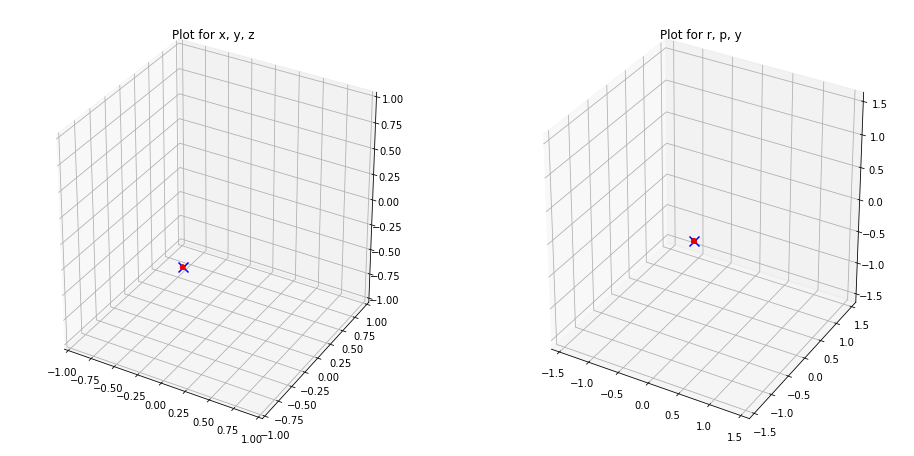

In [32]:
# Retrieve clusters
from sklearn.cluster import KMeans

num_clusters = 1

kmeans_model = KMeans(n_clusters = num_clusters).fit(S_new[:-1, :].T)
results = kmeans_model.cluster_centers_
print(results)

res = results.T

fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(*S_new[:3,:m//4], zdir='z', c='red', alpha=0.1)
ax1.scatter(*res[:3,:], zdir='z', c='blue', marker='x', s=100)
ax1.set_xlim3d(-1, 1)
ax1.set_ylim3d(-1, 1)
ax1.set_zlim3d(-1, 1)
ax1.set_title("Plot for x, y, z")

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(*S_new[3:,:200], c='red', alpha=0.05)
ax2.scatter(*res[3:,:], zdir='z', c='blue', marker='x', s=100)
ax2.set_xlim3d(-pi/2, pi/2)
ax2.set_ylim3d(-pi/2, pi/2)
ax2.set_zlim3d(-pi/2, pi/2)
ax2.set_title("Plot for r, p, y")
plt.show()

In [33]:
# Compare translation with ground truth by normalising both vectors
gt = np.array([diff, diff, diff])
for res_idx in range(results.shape[0]):
    t  = results[res_idx, :3]
    print("Solution t:   " + str(t/np.linalg.norm(t)))
    print("Ground truth: " + str(gt/np.linalg.norm(gt)))
    print("Difference:   " + str(t/np.linalg.norm(t) - gt/np.linalg.norm(gt)))
    print()

Solution t:   [-0.48306586 -0.42095827 -0.76775094]
Ground truth: [-0.57735027 -0.57735027 -0.57735027]
Difference:   [ 0.09428441  0.156392   -0.19040067]



In [34]:
# Compare rotation with ground truth by taking modulo wrt. 2pi
gt = np.array([diff, diff, diff]) % (2*pi)
for res_idx in range(results.shape[0]):
    r = results[res_idx, 3:] % (2*pi)
    print("Solution r:   " + str(r))
    print("Ground truth: " + str(gt))

    diff_r = np.minimum((r - gt) % (2*pi), (gt - r) % (2*pi))
    print("Difference:   " + str(diff_r))
    print()

Solution r:   [6.13286402 6.19359479 5.98818309]
Ground truth: [6.08318531 6.08318531 6.08318531]
Difference:   [0.04967871 0.11040948 0.09500222]



In [35]:
# Construct E from solution t and r, check that (pts1)' T (pts2) = 0

from helpers import rpy2R, xyz2T

pts1_uvf = np.concatenate((pts1, np.ones((pts1.shape[0], 1))), axis = 1)
pts2_uvf = np.concatenate((pts2, np.ones((pts2.shape[0], 1))), axis = 1)

for res_idx in range(results.shape[0]):
    t  = results[res_idx, :3]
    r  = results[res_idx, 3:]
    
    T = xyz2T(t[0], t[1], t[2])
    R = rpy2R(r[0], r[1], r[2])
    
    print("Result number: " + str(res_idx))
    for i in range(pts1_uvf.shape[0]):
        print(pts1_uvf[i, :] @ T @ R @ pts2_uvf[i, :].T)
    print()

Result number: 0
-0.0055650011615237804
0.014612366051650505
-0.0018817990676569599
-0.0005628797796916052
-0.027341004650156375
-0.015929524975216797
-0.00037486218554903805
-0.019737545782247568
0.008573554007028597
0.0012048905474021099
-0.01445983035990367
-0.0018518471572132461
-0.0015542899668506832
-0.01712991448154988
0.004607592329290255
-0.02187338430270494
-0.003322744276701565
-0.004352706199151769
-0.022551037844230765
-0.014544997351519262



In [36]:
# Ground truth check of (pts1)' T (pts2) = 0 for comparison
from helpers import rpy2R, xyz2T

t = np.array([diff, diff, diff, diff, diff, diff])

T = xyz2T(t[0], t[1], t[2])
R = rpy2R(t[3], t[4], t[5])
E = np.dot(T, R)

for i in range(pts1_uvf.shape[0]):
    print(pts1_uvf[i, :] @ E @ pts2_uvf[i, :].T)

1.3877787807814457e-17
0.0
6.938893903907228e-18
5.551115123125783e-17
-2.7755575615628914e-17
1.3877787807814457e-17
0.0
2.7755575615628914e-17
0.0
0.0
1.3877787807814457e-17
0.0
0.0
2.7755575615628914e-17
1.1102230246251565e-16
0.0
0.0
6.938893903907228e-18
3.729655473350135e-17
0.0
